<a href="https://colab.research.google.com/github/AJ-Benjamin/hate-speech-detection-project/blob/main/hate_speech_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd

### Get helper functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-02-27 14:15:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-27 14:15:42 (74.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
# Downloading the data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

print("Path to dataset files:", path)

100%|██████████| 114M/114M [00:02<00:00, 50.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/versions/1


In [5]:
import os

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset folder:", files)

Files in dataset folder: ['HateSpeechDataset.csv', 'HateSpeechDatasetBalanced.csv']


In [6]:
# Reading in the data and visualizing
df = pd.read_csv('/content/drive/MyDrive/Hate_speech_dataset/HateSpeechDatasetBalanced.csv')
df

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
...,...,...
726114,i mute this telecasting and played kanye west ...,1
726115,but hell yeah he s not a bachelor but looooooo...,1
726116,great video musician but s not my musician lol...,1
726117,not great pop video yeah he s not a pedophile ...,1


In [7]:
# How many examples of each class?
df["Label"].value_counts() # fairly balanced

,count
Label,
1,364525
0,361594


In [8]:
# shuffle our dataframe
df_shuffled = df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
df_shuffled.head()

,Content,Label
615013,you should be deeply embarrassed... by not ful...,1
75913,do not make me make you fall in love with a bi...,0
523130,trump america is anti immigrant sexual activit...,1
682117,you guys are clearly a pole smoker please get ...,1
395535,oh come along the only reason people like stri...,0


* 1 = hate speech
* 0 = not hate speech

In [9]:
print(f"Total samples: {len(df)}")

Total samples: 726119


In [10]:
# Visualizing some random training examples
import random
random_index = random.randint(0, len(df)-5)  # create random indexes not higher than the total number of samples
for row in df_shuffled[["Content", "Label"]][random_index:random_index+5].itertuples():
  _,Content, Label = row
  print(f"Label: {Label}", "(hate speech)" if Label > 0 else "(not hate speech)")
  print(f"Content: \n{Content}\n")
  print("-----")

Label: 0 (not hate speech)
Content: 
above posted by on at utc than what msg seems to be related to some comment i once left at to someone writing in german here in the english wikipedia

-----
Label: 0 (not hate speech)
Content: 
your comment unconstructive eh

-----
Label: 0 (not hate speech)
Content: 
el porno gay mas rare que he vito en mi vida i need

-----
Label: 0 (not hate speech)
Content: 
yes it is i see clayton what a slut responsible for the design of wainwright s d class cab and splashes as well

-----
Label: 1 (hate speech)
Content: 
think about you smoking

-----


### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

# use train_test_split to split df training  data into training and validation dataset
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df_shuffled["Content"].to_numpy(),
                                                                            df_shuffled["Label"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [12]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df_shuffled["Content"].to_numpy(),
                                                                            df_shuffled["Label"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)

In [13]:
# check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(653507, 653507, 72612, 72612)

In [14]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['travellers alike mentioned things',
        'fuck you my orders were legit paula been this fucking obese dude it is a fact however does the opinion be as this inane list of rules at the top of those pages also go get laid die',
        'i have a million valid arguments does i cry now',
        'liquid crystal display glad that storm stopped you no good boy of a beef how could you possibly abet something like that',
        'this nigga over it here constantly telling me he still does not who fuck with her this bitch when he does weary face face with sobbing tears of joy face on with tears weep of joy or else maybe she s lying laughing out damned loud',
        'yes buildthatwall like that down you go now',
        'he and like me make filth look before the mirror all are jewish',
        'wikipediatube does not require that references be credible have not you read the guidelines two pops for yes',
        'snoop friend official member snoop friend is considered a official membe

### Converting text into numbers


### Text vectorization (tokenization)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None)  # how long should the output sequence of tokens be?


In [16]:
# Find the average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


36

In [17]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 36 # max length our sentences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 36), dtype=int64, numpy=
array([[9000,    4, 6806,   13,   25, 1172,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text: 
i am actually inclined to agree with this i will trim it cheers      

Vectorized version:


<tf.Tensor: shape=(1, 36), dtype=int64, numpy=
array([[   6,   35,  187, 6212,    3,  325,   23,   16,    6,   34, 8702,
          11,  845,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens ([UNK] token for "unknown" and '' for space)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'to', 'a']
Bottom 5 least common words: ['sterilized', 'statue', 'spoil', 'sneaky', 'shady']


### Creating an Embedding using an Embedding Layer


In [22]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform",# default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [23]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
please stay safe you guys i love you so much i hoe to one day meet you guys happy halloween happy face or smiley      

Embedded version:


<tf.Tensor: shape=(1, 36, 128), dtype=float32, numpy=
array([[[ 0.02387938, -0.03532275,  0.02184934, ..., -0.04408738,
          0.03282965, -0.04794246],
        [-0.00279962,  0.03935433, -0.04414814, ...,  0.04834168,
         -0.02491531,  0.04296911],
        [-0.00660335,  0.03882358, -0.00646377, ...,  0.04763431,
         -0.00032683, -0.02914356],
        ...,
        [ 0.01615621,  0.04728291, -0.02392285, ..., -0.04036019,
          0.00801498,  0.01410553],
        [ 0.01615621,  0.04728291, -0.02392285, ..., -0.04036019,
          0.00801498,  0.01410553],
        [ 0.01615621,  0.04728291, -0.02392285, ..., -0.04036019,
          0.00801498,  0.01410553]]], dtype=float32)>

In [24]:
# Check out a  single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02387938, -0.03532275,  0.02184934, -0.00515722, -0.04203551,
        0.03520017, -0.01802767,  0.00267758, -0.02703829, -0.00200184,
       -0.04840192, -0.01144999, -0.01067642, -0.00366266, -0.01072066,
        0.00805927, -0.01966429, -0.02788335,  0.02937675,  0.03514589,
        0.01810488,  0.02895471, -0.03387473, -0.03269831,  0.02092988,
       -0.02613838,  0.03893722,  0.01106348, -0.03002127, -0.02053839,
        0.0479953 ,  0.02276054,  0.0264785 ,  0.03130129, -0.02003393,
       -0.01098467, -0.02826847, -0.04734547,  0.03395671,  0.01755038,
       -0.01307496,  0.01407749,  0.03663759,  0.01116903,  0.02001495,
        0.04859218, -0.00166519, -0.02807771, -0.00855917,  0.00294614,
       -0.02970269, -0.01675721,  0.04514762, -0.02975588,  0.04478209,
        0.01324402,  0.00653993,  0.0098951 ,  0.01947624,  0.04322908,
        0.01390669, -0.02697127,  0.04070411, -0.02470014, -0.00522857,
        0.033916

### Model 0: Getting a base line (Naive Bayes)


In [25]:
len(train_sentences)

653507

Since the train_sentences data is very large, running these models on them will take a very long time. To cut down on the time, let use 1% (0.01) of the total training data.

In [26]:
int(0.01 * len(train_sentences))

6535

In [27]:
one_percent_train_sentences = train_sentences[:int(0.01 * len(train_sentences)+1)]
one_percent_train_labels = train_labels[:int(0.01 * len(train_labels)+1)]

In [28]:
len(one_percent_train_sentences)

6536

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(one_percent_train_sentences, one_percent_train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 76.85%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

### Creating an evaluation function for our model experiments

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 76.85368809563158,
 'precision': 0.7685488099077005,
 'recall': 0.7685368809563158,
 'f1': 0.768530159295947}

### Model 1: A simple dense model

In [34]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 36)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 36, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Fit the model
model_1_history = model_1.fit(one_percent_train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20250227-141644
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.5880 - loss: 0.6701 - val_accuracy: 0.6603 - val_loss: 0.6100
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7061 - loss: 0.5723 - val_accuracy: 0.7410 - val_loss: 0.5344
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7912 - loss: 0.4735 - val_accuracy: 0.7564 - val_loss: 0.5007
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8279 - loss: 0.4063 - val_accuracy: 0.7641 - val_loss: 0.4857
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8568 - loss: 0.3558 - val_accuracy: 0.7682 - val_loss: 0.4819


In [39]:

# Check the results
model_1.evaluate(val_sentences, val_labels)

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7658 - loss: 0.4852


[0.4819188117980957, 0.7681512832641602]

In [40]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


array([[0.8691522 ],
       [0.505252  ],
       [0.74229765],
       [0.45742208],
       [0.9594175 ],
       [0.581998  ],
       [0.22050087],
       [0.07293873],
       [0.0216083 ],
       [0.5290693 ]], dtype=float32)

In [41]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1.], dtype=float32)>

In [42]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 76.81512697625736,
 'precision': 0.7688617884416499,
 'recall': 0.7681512697625736,
 'f1': 0.7680236285529026}

In [43]:
# comparing our simple keras model to our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))


array([False,  True, False, False])

In [44]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 76.85, New accuracy: 76.82, Difference: -0.04
Baseline precision: 0.77, New precision: 0.77, Difference: 0.00
Baseline recall: 0.77, New recall: 0.77, Difference: -0.00
Baseline f1: 0.77, New f1: 0.77, Difference: -0.00


### Model 2: LSTM

In [45]:
# Set random and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 36, 128)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
# compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 36)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 36, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Fit model
model_2_history = model_2.fit(one_percent_train_sentences,
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])


Saving TensorBoard log files to: model_logs/LSTM/20250227-141811
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - accuracy: 0.6108 - loss: 0.6572 - val_accuracy: 0.7556 - val_loss: 0.5205
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 48s 236ms/step - accuracy: 0.7867 - loss: 0.4815 - val_accuracy: 0.7534 - val_loss: 0.5099
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.8518 - loss: 0.3552 - val_accuracy: 0.7442 - val_loss: 0.6590
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.8925 - loss: 0.2729 - val_accuracy: 0.7376 - val_loss: 0.7758
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.9113 - loss: 0.2337 - val_accuracy: 0.7481 - val_loss: 0.6724


In [49]:
# Make predicitons on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # View the first 10

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step


((72612, 1),
 array([[0.06392466],
        [0.4153328 ],
        [0.8285896 ],
        [0.95323557],
        [0.9792864 ],
        [0.94418836],
        [0.02363585],
        [0.01544025],
        [0.01509691],
        [0.33724892]], dtype=float32))

In [50]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [51]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.81270313446812,
 'precision': 0.7483526260426111,
 'recall': 0.7481270313446813,
 'f1': 0.7480865744416322}

In [52]:
# Comapre model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 76.85, New accuracy: 74.81, Difference: -2.04
Baseline precision: 0.77, New precision: 0.75, Difference: -0.02
Baseline recall: 0.77, New recall: 0.75, Difference: -0.02
Baseline f1: 0.77, New f1: 0.75, Difference: -0.02


### Model 3: GRU (Gated Recurrent Unit)

In [53]:
# Set random seed and create embedding layer  (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True)  # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)  # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 36)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 36, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Fit model
model_3_history = model_3.fit(one_percent_train_sentences,
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20250227-142251
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - accuracy: 0.5729 - loss: 0.6780 - val_accuracy: 0.6649 - val_loss: 0.5977
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.7190 - loss: 0.5586 - val_accuracy: 0.7567 - val_loss: 0.5242
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.8354 - loss: 0.3857 - val_accuracy: 0.7580 - val_loss: 0.5285
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.8965 - loss: 0.2580 - val_accuracy: 0.7278 - val_loss: 0.6767
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 49s 184ms/step - accuracy: 0.9338 - loss: 0.1781 - val_accuracy: 0.7470 - val_loss: 0.7068


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step


((72612, 1),
 array([[0.45242444],
        [0.6177598 ],
        [0.94109094],
        [0.59352326],
        [0.98475206],
        [0.93171734],
        [0.00238132],
        [0.00211503],
        [0.00484265],
        [0.9229001 ]], dtype=float32))

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 1., 1., 0., 0., 0., 1.], dtype=float32)>

In [59]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 74.6997741420151,
 'precision': 0.7473650124541259,
 'recall': 0.746997741420151,
 'f1': 0.7469256112674155}

In [60]:
# Compile to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 76.85, New accuracy: 74.70, Difference: -2.15
Baseline precision: 0.77, New precision: 0.75, Difference: -0.02
Baseline recall: 0.77, New recall: 0.75, Difference: -0.02
Baseline f1: 0.77, New f1: 0.75, Difference: -0.02


### Model 4: Bidirectional RNN model

In [61]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 36)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 36, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Fit the model
model_4_history = model_4.fit(one_percent_train_sentences,
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20250227-142623
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 49s 219ms/step - accuracy: 0.6221 - loss: 0.6396 - val_accuracy: 0.7584 - val_loss: 0.4940
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 54s 264ms/step - accuracy: 0.8369 - loss: 0.3843 - val_accuracy: 0.7465 - val_loss: 0.5335
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.9005 - loss: 0.2462 - val_accuracy: 0.7483 - val_loss: 0.6648
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 82s 263ms/step - accuracy: 0.9389 - loss: 0.1704 - val_accuracy: 0.7315 - val_loss: 0.9144
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 74s 225ms/step - accuracy: 0.9505 - loss: 0.1435 - val_accuracy: 0.7506 - val_loss: 0.7725


In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step


array([[7.19294548e-01],
       [8.46325696e-01],
       [9.20280635e-01],
       [3.96721112e-03],
       [9.93629634e-01],
       [9.44387794e-01],
       [1.42937265e-02],
       [2.05809926e-03],
       [5.76339371e-04],
       [9.20952499e-01]], dtype=float32)

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 1., 1., 0., 0., 0., 1.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.0605960447309,
 'precision': 0.7506062165529345,
 'recall': 0.750605960447309,
 'f1': 0.7506060712742375}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 76.85, New accuracy: 75.06, Difference: -1.79
Baseline precision: 0.77, New precision: 0.75, Difference: -0.02
Baseline recall: 0.77, New recall: 0.75, Difference: -0.02
Baseline f1: 0.77, New f1: 0.75, Difference: -0.02


### Model 5: Conv1D

In [69]:
# # Test out the embedding, 1D convolutional and max pooling
# embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
# conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
# conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
# max_pool = layers.GlobalMaxPool1D()
# max_pool_output = max_pool(conv_1d_output) # get the most important features
# embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

In [70]:
# # See the outputs of each layer
# embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

In [71]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 36)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 36, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 32, 32)              │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Fit the model
model_5_history = model_5.fit(one_percent_train_sentences,
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])


Saving TensorBoard log files to: model_logs/Conv1D/20250227-143238
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.5918 - loss: 0.6648 - val_accuracy: 0.7325 - val_loss: 0.5376
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.8058 - loss: 0.4489 - val_accuracy: 0.7658 - val_loss: 0.4948
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.8997 - loss: 0.2633 - val_accuracy: 0.7598 - val_loss: 0.5557
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9539 - loss: 0.1445 - val_accuracy: 0.7546 - val_loss: 0.6423
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9796 - loss: 0.0740 - val_accuracy: 0.7501 - val_loss: 0.7379


In [73]:

# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


array([[0.3439802 ],
       [0.31270993],
       [0.96721584],
       [0.97219366],
       [0.99675107],
       [0.99953216],
       [0.09565803],
       [0.00234136],
       [0.01561778],
       [0.4448882 ]], dtype=float32)

In [74]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [75]:
# Calculate model_5 evaluate metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.00964027984355,
 'precision': 0.7500996322224829,
 'recall': 0.7500964027984355,
 'f1': 0.7500969653143527}

In [76]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 76.85, New accuracy: 75.01, Difference: -1.84
Baseline precision: 0.77, New precision: 0.75, Difference: -0.02
Baseline recall: 0.77, New recall: 0.75, Difference: -0.02
Baseline f1: 0.77, New f1: 0.75, Difference: -0.02


### Using Pretrained Embeddings (transfer learning for NLP)


#### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [77]:
# Using pretrained embedding with universasl sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true")
embed_samples = embed([sample_sentence, # Earlier assigned above
                       "I am a sentence for which I would like to get its embedding"])
print(embed_samples[0][:50])


tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [78]:
# Each sentence has been encoded into a 512 dimension vector
# embed_samples[0].shape

In [79]:
# # To convert the TensorFlow Hub USE module into a Keras layer
# # We can use this encoding layer in place of our text_vectorizer and embedding layer
# sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true",
#                                         input_shape=[], # shape of inputs coming to our model
#                                         dtype=tf.string, # data type of inputs coming to the USE layer
#                                         trainable=False, # keep the pretrained weights
#                                         name="USE")

In [80]:
# # Create model using the Sequential API
# model_6 = tf.keras.Sequential([
#     layers.Input(shape=(), dtype=tf.string),
#     sentence_encoder_layer,  # take in sentences and then encode them into an embedding
#     layers.Dense(64, activation="relu"),
#     layers.Dense(1, activation="sigmoid")
# ], name="model_6_USE")

# # compile model
# model_6.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizer.Adam(),
#                 metrics=["accuracy"])

# model_6.summary()

In [81]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Load the USE model from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    dtype=tf.string,
    trainable=False,
    name="USE"
)

# Functional API
inputs = layers.Input(shape=(), dtype=tf.string, name="input_text")  # Input layer

# Wrap USE in Lambda with explicit output shape
embedding = layers.Lambda(lambda x: sentence_encoder_layer(x), output_shape=(512,))(inputs)

x = layers.Dense(64, activation="relu")(embedding)  # Fully connected layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer

# Create model
model_6 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print model summary
model_6.summary()


Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(one_percent_train_sentences,
                              one_percent_train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250227-143527
Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.7059 - loss: 0.6095 - val_accuracy: 0.7671 - val_loss: 0.4845
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 218ms/step - accuracy: 0.7722 - loss: 0.4711 - val_accuracy: 0.7783 - val_loss: 0.4651
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.7857 - loss: 0.4453 - val_accuracy: 0.7813 - val_loss: 0.4586
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 214ms/step - accuracy: 0.7925 - loss: 0.4300 - val_accuracy: 0.7839 - val_loss: 0.4552
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 83s 218ms/step - accuracy: 0.8039 - loss: 0.4178 - val_accuracy: 0.7858 - val_loss: 0.4531


In [83]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step


array([[0.9388084 ],
       [0.701207  ],
       [0.79695743],
       [0.26431164],
       [0.97486436],
       [0.7346191 ],
       [0.8666925 ],
       [0.8580926 ],
       [0.07086255],
       [0.70768374]], dtype=float32)

In [84]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)>

In [85]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 78.58480691896656,
 'precision': 0.7871733948997612,
 'recall': 0.7858480691896657,
 'f1': 0.785569374526612}

In [86]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 76.85, New accuracy: 78.58, Difference: 1.73
Baseline precision: 0.77, New precision: 0.79, Difference: 0.02
Baseline recall: 0.77, New recall: 0.79, Difference: 0.02
Baseline f1: 0.77, New f1: 0.79, Difference: 0.02


### Comparing the performance of each of our models

In [87]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,76.853688,0.768549,0.768537,0.768530
simple_dense,76.815127,0.768862,0.768151,0.768024
lstm,74.812703,0.748353,0.748127,0.748087
gru,74.699774,0.747365,0.746998,0.746926
bidirectional,75.060596,0.750606,0.750606,0.750606
conv1d,75.009640,0.750100,0.750096,0.750097
tf_hub_sentence_encoder,78.584807,0.787173,0.785848,0.785569


In [88]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

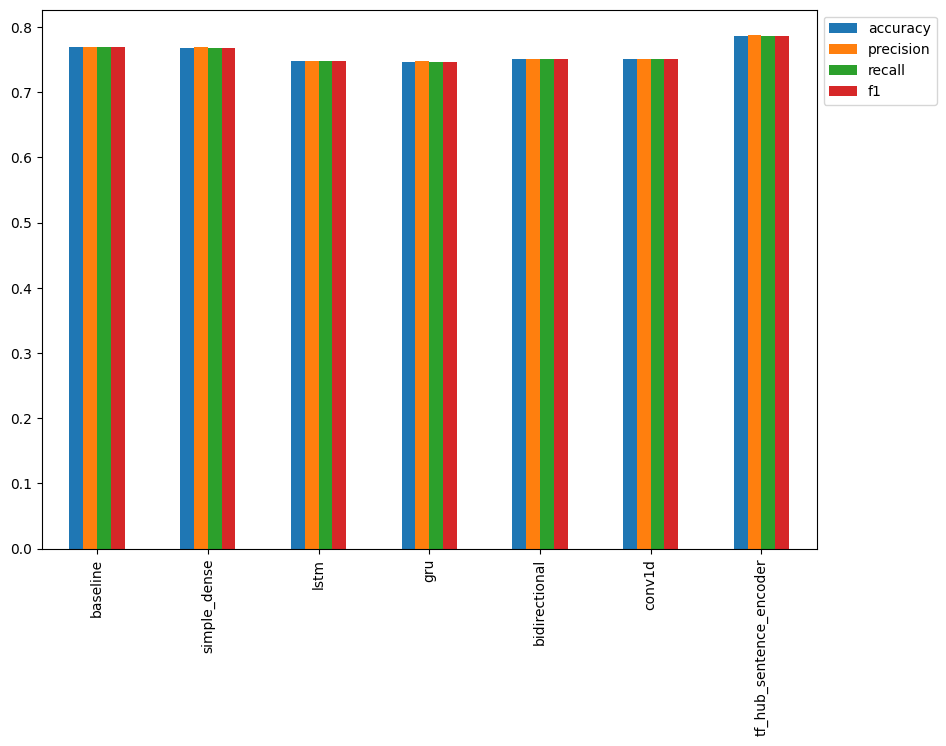

In [89]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

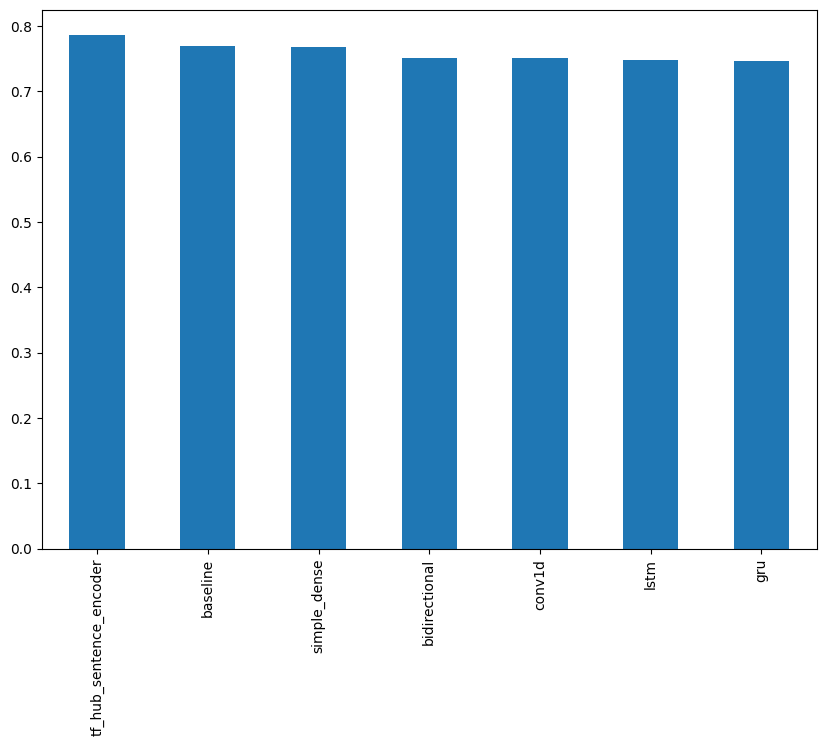

In [90]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


### Combining our models (model ensembling/stacking)

Having seen what works that `tf_hub_sentence_encoder` and `baseline` are the best performing. Before combining our models, We will run both on the full dataset. (it will take a lot of time). We will also run the `lstm` model for the sake adding an uncorrelated model.


In [91]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [92]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 81.66%


In [93]:
# Make predictions
baseline_preds= model_0.predict(val_sentences)

In [94]:
# Get baseline results
baseline_results= calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 81.65730182339007,
 'precision': 0.8219615344853219,
 'recall': 0.8165730182339007,
 'f1': 0.8157550268335224}

In [95]:
# Set random and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 36, 128)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [96]:
# compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [97]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])


Saving TensorBoard log files to: model_logs/LSTM/20250227-144258
Epoch 1/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 949s 46ms/step - accuracy: 0.8032 - loss: 0.4169 - val_accuracy: 0.8483 - val_loss: 0.3369
Epoch 2/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 953s 45ms/step - accuracy: 0.8569 - loss: 0.3184 - val_accuracy: 0.8602 - val_loss: 0.3148
Epoch 3/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 920s 45ms/step - accuracy: 0.8810 - loss: 0.2712 - val_accuracy: 0.8626 - val_loss: 0.3146
Epoch 4/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 926s 45ms/step - accuracy: 0.9007 - loss: 0.2320 - val_accuracy: 0.8639 - val_loss: 0.3294
Epoch 5/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 979s 45ms/step - accuracy: 0.9163 - loss: 0.2003 - val_accuracy: 0.8636 - val_loss: 0.3487


In [98]:
# Make predicitons on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # View the first 10

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step


((72612, 1),
 array([[9.8487544e-01],
        [8.7262020e-03],
        [9.9575746e-01],
        [8.8586938e-04],
        [9.9989831e-01],
        [9.9822891e-01],
        [1.1092773e-02],
        [4.1807492e-04],
        [2.8591722e-03],
        [9.6956635e-01]], dtype=float32))

In [99]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 0., 1., 1., 0., 0., 0., 1.], dtype=float32)>

In [100]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 86.36175838704347,
 'precision': 0.8641437198583946,
 'recall': 0.8636175838704346,
 'f1': 0.8635586655111126}

In [101]:
# Comapre model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 81.66, New accuracy: 86.36, Difference: 4.70
Baseline precision: 0.82, New precision: 0.86, Difference: 0.04
Baseline recall: 0.82, New recall: 0.86, Difference: 0.05
Baseline f1: 0.82, New f1: 0.86, Difference: 0.05


In [102]:
# Using pretrained embedding with universasl sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true")
embed_samples = embed([sample_sentence, # Earlier assigned above
                       "I am a sentence for which I would like to get its embedding"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [103]:
# Load the USE model from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    dtype=tf.string,
    trainable=False,
    name="USE"
)

# Functional API
inputs = layers.Input(shape=(), dtype=tf.string, name="input_text")  # Input layer

# Wrap USE in Lambda with explicit output shape
embedding = layers.Lambda(lambda x: sentence_encoder_layer(x), output_shape=(512,))(inputs)

x = layers.Dense(64, activation="relu")(embedding)  # Fully connected layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer

# Create model
model_6 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print model summary
model_6.summary()


Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_text (InputLayer)              │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250227-160301
Epoch 1/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 542s 26ms/step - accuracy: 0.7999 - loss: 0.4292 - val_accuracy: 0.8210 - val_loss: 0.3906
Epoch 2/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 561s 26ms/step - accuracy: 0.8256 - loss: 0.3833 - val_accuracy: 0.8262 - val_loss: 0.3802
Epoch 3/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 579s 28ms/step - accuracy: 0.8326 - loss: 0.3703 - val_accuracy: 0.8287 - val_loss: 0.3760
Epoch 4/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 582s 26ms/step - accuracy: 0.8367 - loss: 0.3622 - val_accuracy: 0.8292 - val_loss: 0.3741
Epoch 5/5
20423/20423 ━━━━━━━━━━━━━━━━━━━━ 560s 26ms/step - accuracy: 0.8396 - loss: 0.3566 - val_accuracy: 0.8297 - val_loss: 0.3729


In [105]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step


array([[0.95561624],
       [0.57846594],
       [0.76464224],
       [0.44271222],
       [0.9803836 ],
       [0.623134  ],
       [0.34459475],
       [0.6608703 ],
       [0.07473809],
       [0.66753167]], dtype=float32)

In [106]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 1., 1., 0., 1., 0., 1.], dtype=float32)>

In [107]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 82.96700269927835,
 'precision': 0.8302255002735939,
 'recall': 0.8296700269927836,
 'f1': 0.8295845509849947}

In [108]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 81.66, New accuracy: 82.97, Difference: 1.31
Baseline precision: 0.82, New precision: 0.83, Difference: 0.01
Baseline recall: 0.82, New recall: 0.83, Difference: 0.01
Baseline f1: 0.82, New f1: 0.83, Difference: 0.01


In [109]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "lstm": model_2_results,
                                  "tf_hub_sentence_encoder": model_6_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,81.657302,0.821962,0.816573,0.815755
lstm,86.361758,0.864144,0.863618,0.863559
tf_hub_sentence_encoder,82.967003,0.830226,0.829670,0.829585


In [110]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

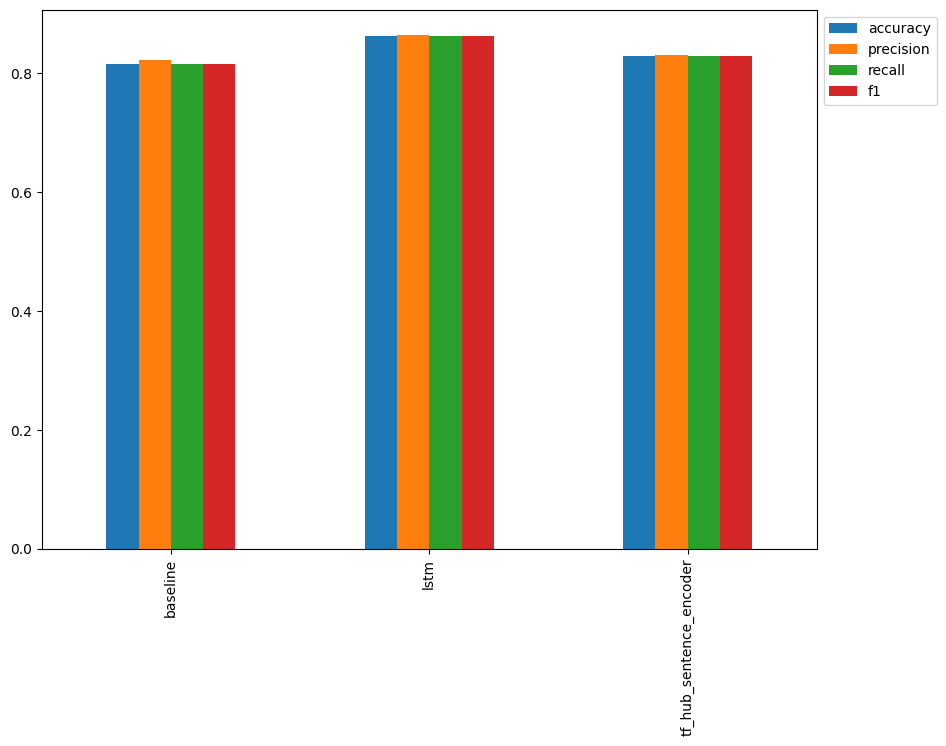

In [111]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

### Combining our models (model ensembling/stacking)

In [112]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 1.], dtype=float32)>

In [113]:
# Calculate results from averaging the prediciton probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 86.9580785545089,
 'precision': 0.8764566313844697,
 'recall': 0.869580785545089,
 'f1': 0.8689505979888685}

In [114]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [115]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


<ipython-input-115-eb0b96b5da6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [116]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.816573,0.821962,0.816573,0.815755
lstm,0.863618,0.864144,0.863618,0.863559
tf_hub_sentence_encoder,0.829670,0.830226,0.829670,0.829585
ensemble_results,86.958079,0.876457,0.869581,0.868951


### Saving and Loading a trained model

In [117]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_6.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Save TF Hub Sentence Encoder model to  keras
model_6.save("model_6.keras")

In [ ]:
# # How does our loaded model perform?
# loaded_model_6.evaluate(val_sentences, val_labels)

In [ ]:
# # Save TF Hub Sentence Encoder model to SavedModel format (default)
# model_6.save("model_6_SavedModel_format.h5")

In [ ]:
# # Load TF Hub Sentence Encoder SavedModel
# loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")


In [ ]:
# # Evaluate loaded SavedModel format
# loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

### Finding the most wrong examples

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

In [ ]:
# Check the false positive (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

In [ ]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

### Making predicitons on the test dataset

In [ ]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_simple in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

### Predicting on Tweets from the wild

In [ ]:
# Turn Tweet into string
Bens_tweet = "I must blow"

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Use model to make a prediction on sentence.

   Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {psred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

In [ ]:
# Source - https://x.com/Wizarab10/status/1885422778033037577
Wizarab10_tweet = "You fit break up with your partner say two of una na AS. Only for one of you to run test again months or years later and it is AA 😭😭"

# Source - https://x.com/tosinolaseinde/status/1885604986362470796
tosinolaseinde = "What is your personal theme for 2025? Not that of your church or your place of work. Your own theme"

In [ ]:
# Predict on disaster Tweet 1
Predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

In [ ]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

In [ ]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  -----
  model = a trained model
  sample = a list of samples

  Returns:
  -----
  total_time =  total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

In [ ]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");